In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

# 1. 데이터 탐색
## 1.1 문제 정의

이번 데이터의 목적은 집의 정보를 가지고 가격을 예측하는 회귀문제 입니다.

> 평가로는 <u>RMSE</u> 사용


In [0]:
# Loading packages
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

## 1.2 변수설명¶

<Data fields>
- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [0]:
df_train = pd.read_csv('./gdrive/My Drive/GitHub/2019-2nd-ML-month-with-KaKR/data/train.csv')
df_test  = pd.read_csv('./gdrive/My Drive/GitHub/2019-2nd-ML-month-with-KaKR/data/test.csv')

In [8]:
print("train Shape: ",df_train.shape)
print("test Shape: ",df_test.shape)

train Shape:  (15035, 21)
test Shape:  (6468, 20)


In [9]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [25]:
summary = df_train.describe().transpose()
summary

,count,mean,std,min,25%,50%,75%,max
id,15035.0,7517.000000,4340.374984,0.000000,3758.50000,7517.000000,11275.500000,1.503400e+04
price,15035.0,13.048122,0.527471,11.264477,12.68231,13.017005,13.377007,1.585673e+01
bedrooms,15035.0,3.369139,0.902721,0.000000,3.00000,3.000000,4.000000,1.000000e+01
bathrooms,15035.0,2.115065,0.767519,0.000000,1.75000,2.250000,2.500000,8.000000e+00
sqft_living,15035.0,2083.790223,922.134087,290.000000,1430.00000,1910.000000,2560.000000,1.354000e+04
sqft_lot,15035.0,15296.965813,42612.821375,520.000000,5027.50000,7620.000000,10695.500000,1.651359e+06
floors,15035.0,1.498071,0.538522,1.000000,1.00000,1.500000,2.000000,3.500000e+00
waterfront,15035.0,0.007117,0.084063,0.000000,0.00000,0.000000,0.000000,1.000000e+00
view,15035.0,0.234253,0.763376,0.000000,0.00000,0.000000,0.000000,4.000000e+00
condition,15035.0,3.406651,0.646505,1.000000,3.00000,3.000000,4.000000,5.000000e+00


<기본 조건 - feature로 사용 x >
- date : 집을 구매한 날짜 (의미없음)
- price : 집의 가격(Target variable)

<물리적 조건>
- bedrooms :  침실의 갯수 (정수단위)
- bathrooms : 화장실의 갯수 (정수단위)
- floors : 층 

<평가 조건 등급>
- waterfront : 리버뷰 binary (0,1) 
- view : 집이 얼마나 좋아보이는지 등간척도 (0,1,2,3,4)
- condition : 등간척도 (0,1,2,3,4)
- grade : 등간척도 ()

<면적관련>
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)

<연도관련>
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도

<15년 기준 면적 관련>
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

<위치 관련>
- zipcode : 우편번호
- lat : 위도
- long : 경도

>> => 동일 유형 변수은 서로에게 영향을 줄 수 있음


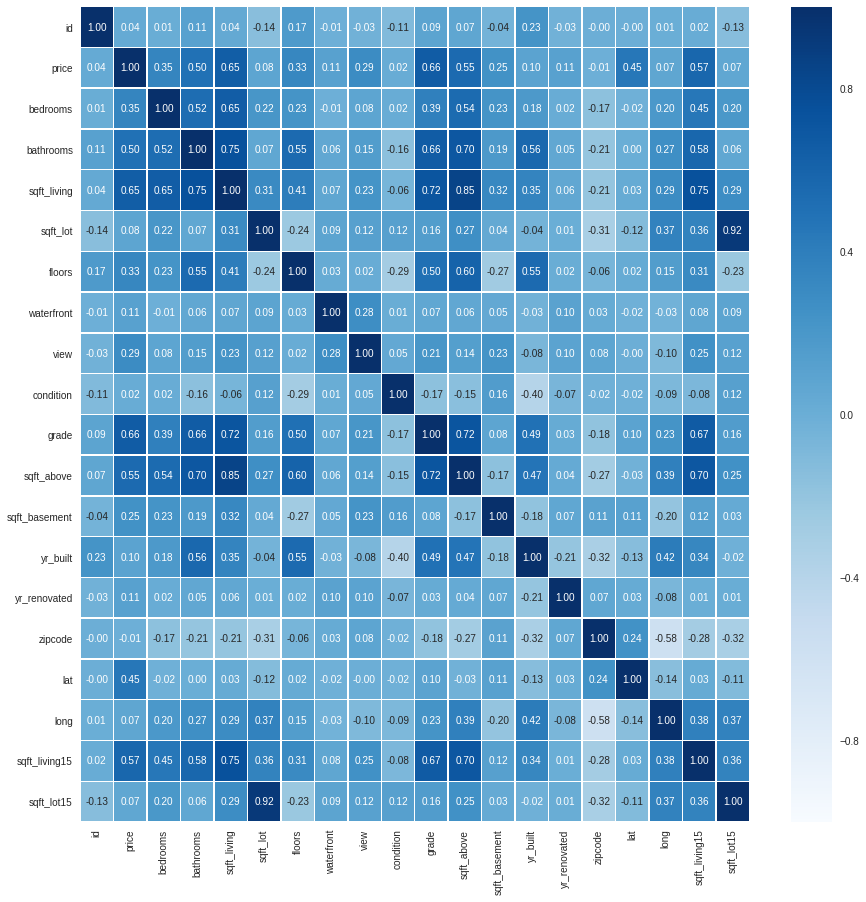

In [28]:
# 전체적인 히트맵
# 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

plt.figure(figsize=(15,15))
sns.heatmap(data = df_train.corr(method='spearman'),annot = True,
           fmt = '.2f',linewidth=.5, cmap = 'Blues')

# 각각의 변수 사이 상관관계 높음 ~> 다중공선성이 존재
# 다중공선성 해결을 위해 robust한 트리모델을 사용해야 함

## 2. 종속변수 (y)
### 2.1 변수 파악

In [10]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [72]:
df_train.sort_values(by='date').head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7160,7160,20140502,12.854487,4,1.75,7.353082,9.071193,1.0,0,0,...,7,7.353082,0.000000,1967,1967.0,98034,47.7274,-122.181,7.640604,8.987322
1788,1788,20140502,12.721889,2,2.00,7.208600,7.848153,1.0,0,0,...,8,7.208600,0.000000,1976,1976.0,98052,47.6344,-122.107,7.490529,7.848153
6219,6219,20140502,13.455976,4,2.25,7.696667,9.328212,1.5,0,0,...,7,7.170888,6.803505,1920,1920.0,98033,47.6845,-122.201,7.749753,9.288689
12138,12138,20140502,12.556733,3,1.75,7.496097,10.047761,1.0,0,0,...,7,7.496097,0.000000,1968,1968.0,98014,47.6517,-121.906,7.252054,9.807197
4734,4734,20140502,13.527830,3,1.75,7.714677,9.266626,2.0,0,0,...,8,7.346655,6.538140,1923,1923.0,98115,47.6954,-122.292,7.359468,9.266626


### 2.2 정규화(Normalization)

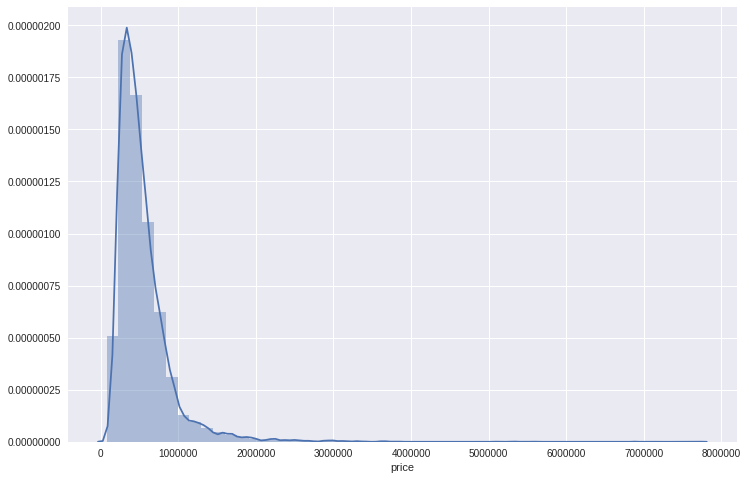

In [16]:
#histogram
f, ax = plt.subplots(figsize=(12, 8))
sns.distplot(df_train['price'])

In [17]:
print('skew',df_train['price'].skew()) 
print('kurtosis',df_train['price'].kurt())

# 좌편향 데이터 -> 로그를 씌워서 정규화!!

skew 4.290252396939529
kurtosis 40.15491919350329


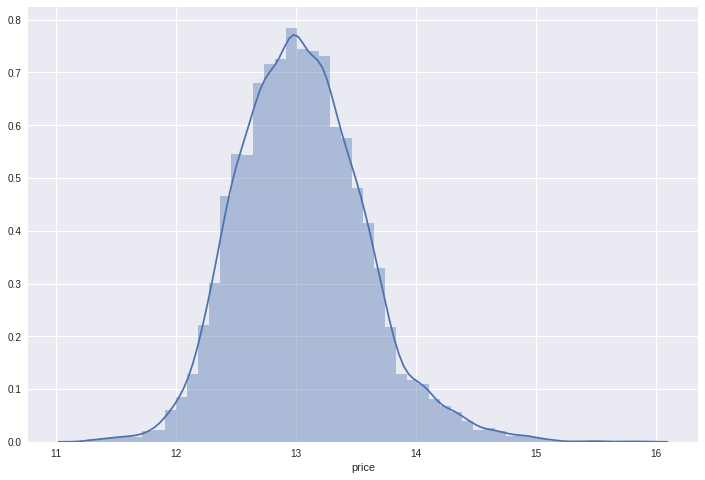

In [18]:
df_train['price'] = np.log1p(df_train['price'])
f, ax = plt.subplots(figsize=(12, 8))
sns.distplot(df_train['price'])

## 3. 독립변수 (x)
### 3.1 종속변수와 연관이 높은 변수


In [30]:
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=11, columns='price').index 
# price과 correlation이 높은 column 10개 뽑기(내림차순)

cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement']


<평가 조건 등급화>
- grade : 	집의 등급 -> 등간척도
- view : 집이 얼마나 좋아보이는지 등간척도 (0,1,2,3,4)

<물리적 조건>
- bedrooms :  침실의 갯수 (정수단위)
- bathrooms : 화장실의 갯수 (정수단위)

<면적관련>
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)

### 3.2 평가 조건 등급

- grade
- view


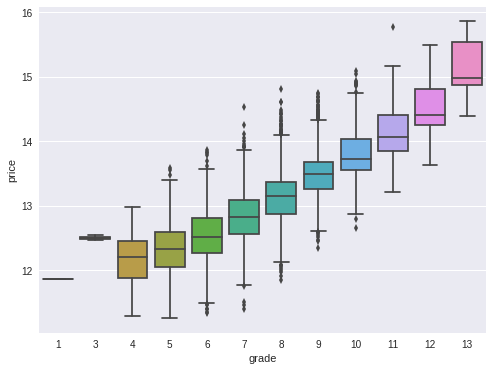

In [31]:
# grade
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

집의 등급이 높으면 가격이 좋음

- 등급 3의 경우 전체적인 값이 크게 편향
- 등급 7,8,9에서 이상치의 range가 큼
- 등급 8과 11에서 차이가 큰 이상치가 나타나는 이유

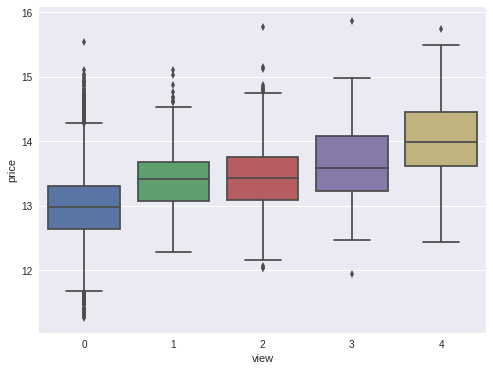

In [34]:
#View
data = pd.concat([df_train['price'], df_train['view']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='view', y="price", data=data)

집의 view가 높으면 가격이 좋을 것이라 판단
대략적인 상승세를 띄고 있지만,

- 등급 0의 경우 range가 큰 이유
- 등급 3에서 차이가 큰 이상치가 나타나는 이유 판단 필요

### 3.3 물리적 조건

- bedrooms :  침실의 갯수 (정수 단위)
- bathrooms : 화장실의 갯수 (정수단위)

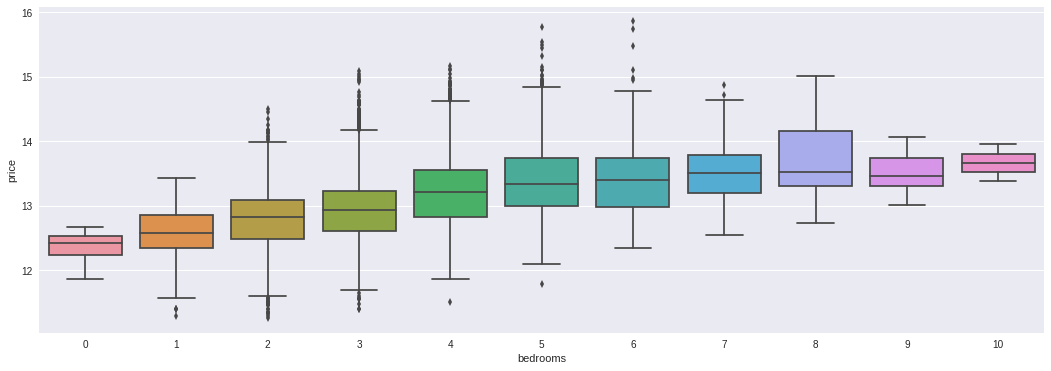

In [36]:
#bedrooms
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)


- 갯수 5,6의 경우 방의 갯수가 작아도 높은 가격의 집들이 있다는 점에 주목해야 함

> => 연도 별 방 갯수의 유행 혹은 지역 별 방 갯수의 선호도가 다르지 않을까하는 생각

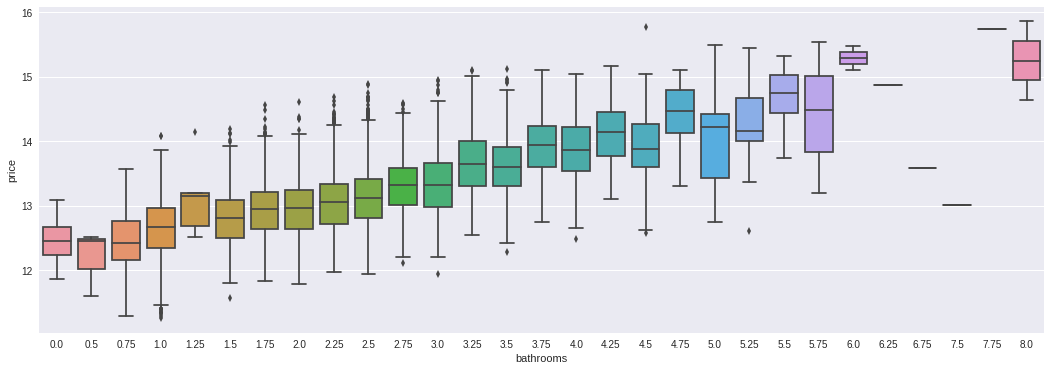

In [35]:
# bathrooms
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

> - 0.5 : 세면대, 화장실
> - 0.75 : 세면대, 화장실, 샤워실
> - 1 : 세면대, 화장실, 샤워실, 욕조

박스플롯으로는 각각의 조합에 대한 정보를 파악할 수 없으므로
이상치에 대한 처리 따로 하지 않음

### 3.4 면적관련

- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)

In [40]:
# sqft_living15와 sqft_living
len(df_train[df_train['yr_renovated']>0])

631

재건축을 한 집 자체가 631개 정도로 적기 때문에 sqft_living15와 sqft_living 의 상관관계는 매우 높을 것으로 사료됨

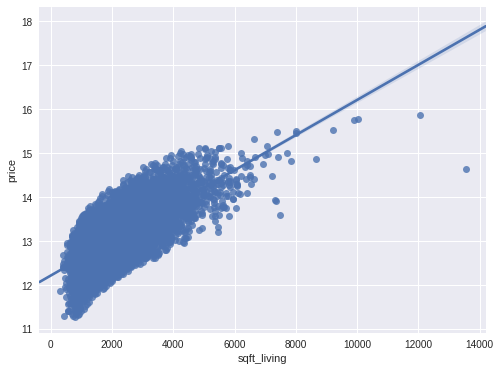

In [41]:
#sqft_living
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

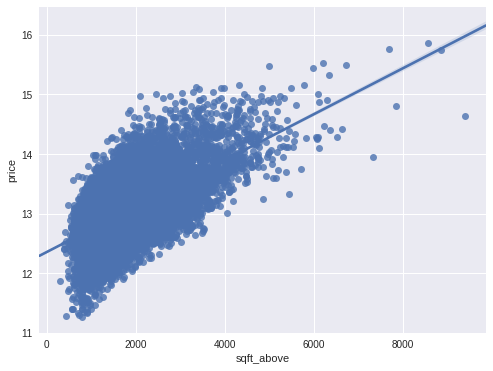

In [42]:
#sqft_above
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

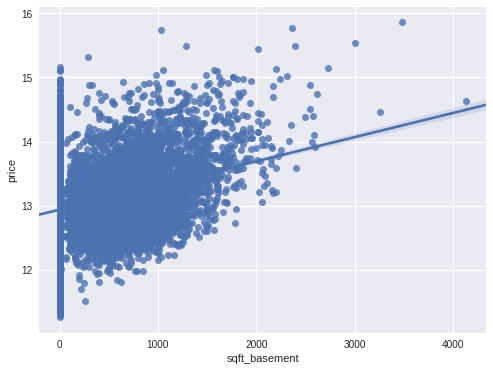

In [43]:
# sqft_basement
data = pd.concat([df_train['price'], df_train['sqft_basement']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_basement', y="price", data=data)

지하실이 아예 없는 경우도 많음 

sqft_basement + sqft_above = 지하실을 포함한 평방 미터


# 2. 데이터 전처리
## 2.1 결측치 처리

In [13]:
df_train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [14]:
df_test.isnull().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

현재 결측치는 존재하지 않다는 것을 알 수 있음

## 2.2 이상치 제거
- grade
- view
- sqft_living





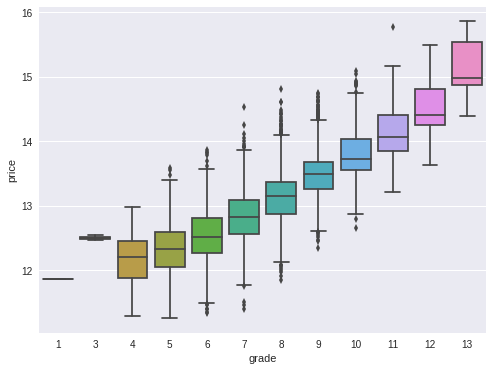

In [44]:
# grade
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [47]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


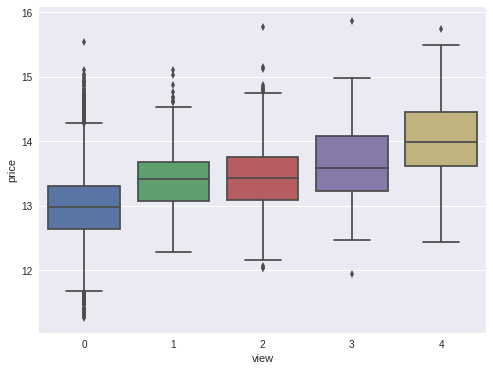

In [48]:
#View
data = pd.concat([df_train['price'], df_train['view']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='view', y="price", data=data)

In [51]:
df_train.loc[(df_train['price']>15.5) & (df_train['view'] == 2)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


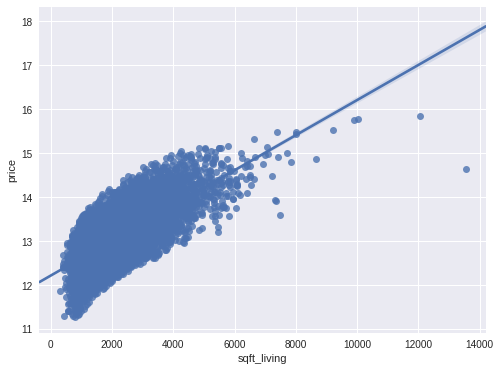

In [52]:
#sqft_living
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [53]:
df_train.loc[(df_train['price']>14.5) & (df_train['sqft_living'] > 12000)]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5108,5108,20141013T000000,15.856731,6,8.0,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [0]:
df_train = df_train.loc[df_train['id']!=2775]
df_train = df_train.loc[df_train['id']!=5108]
df_train = df_train.loc[df_train['id']!=8912]

## 2.3 정규화


In [55]:
print('sqft_living skew',df_train['sqft_living'].skew())
print('sqft_lot skew',df_train['sqft_lot'].skew())
print('sqft_above skew',df_train['sqft_above'].skew())
print('sqft_basement skew',df_train['sqft_basement'].skew())
print('sqft_living15 skew',df_train['sqft_living15'].skew())
print('sqft_lot15 skew',df_train['sqft_lot15'].skew())

sqft_living skew 1.4924715984991939
sqft_lot skew 13.35050013446013
sqft_above skew 1.429070221714329
sqft_basement skew 1.5565549481889323
sqft_living15 skew 1.1259322266124485
sqft_lot15 skew 10.028411904577348


> 모든 변수가 치우쳤음을 알 수 있음 (왜도 1 이상)

In [0]:
#로그를 취하면서, 정규화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement','sqft_living15','sqft_lot15']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

## 2.4 변수 수정

- date : 집을 구매한 날짜
> - 현재 20141013T000000 이러한 형식으로 작성되었기 때문에 날짜만을 추출하여 변수를 수정해야 함

- yr_renovated : 집을 재건축한 년도
> - 재건축이 이루어지지 않았으면, 0으로 표시되기 때문에 이를 단순 건축 년도로 바꾸어 줘야함


In [0]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

## 3. 변수 생성 (Feature Engineering)

지표 변수
